In [ ]:
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import tensorflow as tf

outputpath = '/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/'
NoiseBabble = []
for dirpath,dirnames,filenames in os.walk('/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/'):
    print("present dir: ",dirpath)
    structure = os.path.join(outputpath, dirpath[len('/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/'):])
    for filename in filenames:
        if filename.endswith(".wav"):
            print("wavfile: ",filename)
            sample_rate, samples = wavfile.read(os.path.join(dirpath,filename))
            f, t, Zxx = signal.stft(samples, sample_rate,nperseg=256,nfft=256)
            T = len(t)//16
            #print(Zxx.shape)
            for i in range(0,(T)*16,16):
                NoiseBabble.append(np.log(np.abs(Zxx[:,i:i+16])+1e-8))

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
session = tf.Session(config=config)
with tf.device('/device:GPU:2'):
    import keras
    from keras.models import Sequential
    #from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose,Activation
    from keras.layers.normalization import BatchNormalization
    from keras import backend as K
    import pickle as pk
    batch_size = 1024
    epochs = 50
    import numpy as  np
    import os
    cwd = os.getcwd()
    #x_train = os.path.join(cwd,'Noisy_TCDTIMIT/Babble/20/volunteers/01M/straightcam')
    #y_train = os.path.join(cwd,'Clean/volunteers/01M/straightcam')

    pickle_train = open("noiseBabble.pickle","rb")
    x_train = pk.load(pickle_train)
    pickle_trainlabel = open("cleanBabble.pickle","rb")
    y_train = pk.load(pickle_trainlabel)

    print("Got the input data")
    x_train = np.asarray(x_train[0:100000])
    y_train = np.asarray(y_train[0:100000])
    x_train = x_train.reshape(x_train.shape[0], 129, 16, 1)
    y_train = y_train.reshape(y_train.shape[0], 129, 16, 1)
    print(np.asarray(x_train).shape)

    model2 = Sequential()
    model2.add(BatchNormalization())
    model2.add(Conv2D(64, kernel_size=(7, 7),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(129,16,1)))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2D(128, (5, 5),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2D(256, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2D(256, (1, 1),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    #model.add(Conv2DTranspose(128, (3, 3), activation='relu',padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2DTranspose(128, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2DTranspose(64, (5, 5),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    model2.add(Conv2DTranspose(1, (7, 7),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model2.add(BatchNormalization())
    model2.add(Activation('relu'))
    
    model2.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
                  metrics=['accuracy'])
    model2.build()

    model2.fit(np.asarray(x_train), np.asarray(y_train),
              batch_size=batch_size,
              epochs=epochs,
              validation_split = 0.01
             )

    model2.save_weights('weights_2.h5')

    score = model2.evaluate(x_train, y_train, verbose=0)

    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model2.load_weights('weights_2.h5')

In [30]:
NoiseBabble= []
Phase = []

sample_rate, samples = wavfile.read('/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/20/lipspeakers/Lipspkr2/straightcam/si1035.wav')
f, t, Zxx = signal.stft(samples, sample_rate,nperseg=256,nfft=256)
phase = np.angle(Zxx)
T = len(t)//16
for i in range(0,(T)*16,16):
  NoiseBabble.append(np.log(np.abs(Zxx[:,i:i+16])+1e-8))
  Phase.append(phase[:,i:i+16])
if len(t) % 16 !=0:
  NoiseBabble.append(np.log(np.abs(Zxx[:,len(t)-16:len(t)])+1e-8))
  Phase.append(phase[:,len(t)-16:len(t)])
  T = T+1
NoiseBabble = np.asarray(NoiseBabble)
NoiseBabble = NoiseBabble.reshape(NoiseBabble.shape[0], 129, 16, 1)
rectified =model2.predict(np.asarray(NoiseBabble))
rectified =rectified.reshape(rectified.shape[0], 129, 16)
A = np.zeros((129,0))
for i in range(T):
  S = np.exp(rectified[i])
  A = np.append(A,S*np.cos(Phase[i]) + 1j * S*np.sin(Phase[i]),axis=1)
t,x = signal.istft(A,nperseg=256,nfft=256)
x = np.asarray(x, dtype=np.int16)
wavfile.write('/home/bayten/SpeechDenoisingDNN/codes/babble/testing/si1035.wav', sample_rate, x)

In [31]:
import librosa
from IPython.display import Audio
Audio('/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/20/lipspeakers/Lipspkr2/straightcam/si1035.wav')


In [32]:
Audio("/home/bayten/SpeechDenoisingDNN/codes/babble/testing/si1035.wav")

In [41]:
x, sr = librosa.load('/home/bayten/SpeechDenoisingDNN/codes/babble/Clean/lipspeakers/Lipspkr2/straightcam/si1035.wav')
z, sr = librosa.load('/home/bayten/SpeechDenoisingDNN/codes/babble/Babble/20/lipspeakers/Lipspkr2/straightcam/si1035.wav')
y, sr = librosa.load("/home/bayten/SpeechDenoisingDNN/codes/babble/testing/si1035.wav")

In [34]:
x-y

ValueError: operands could not be broadcast together with shapes (117600,) (118365,) 

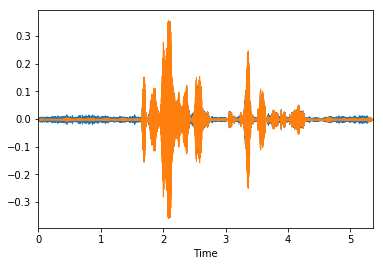

In [49]:
import librosa.display

librosa.display.waveplot(z)
librosa.display.waveplot(y)

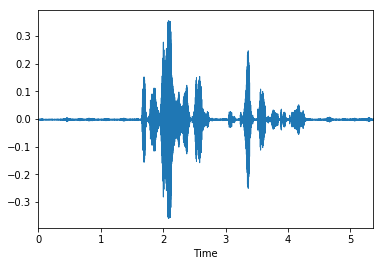

In [46]:
librosa.display.waveplot(y)